In [21]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
1,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
3,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
0,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
2,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [23]:
task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "pretrained"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

In [24]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

n_dims

linear_regression_pretrained pretrained


100%|██████████| 15/15 [00:00<00:00, 483958.15it/s]


20

In [25]:
metrics.keys()


dict_keys(['half_subspace', 'noisyLR', 'orthogonal_train_test', 'overlapping_train_test', 'random_quadrants', 'scale-x=0.333', 'scale-x=0.5', 'scale-x=2', 'scale-x=3', 'scale-y=0.333', 'scale-y=0.5', 'scale-y=2', 'scale-y=3', 'skewed', 'standard'])

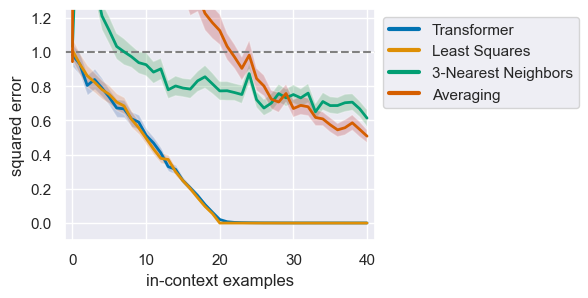

In [26]:

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models) #tiny and small models not provided
plt.show()

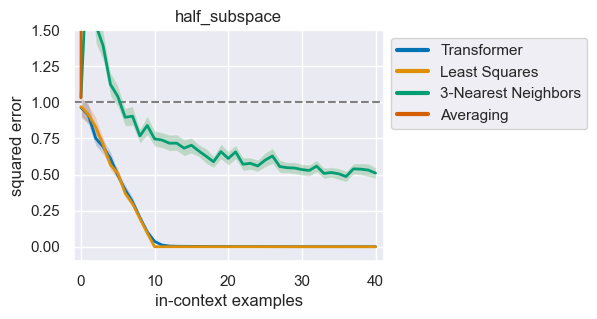

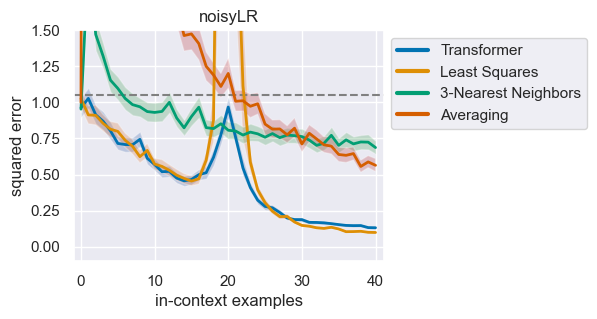

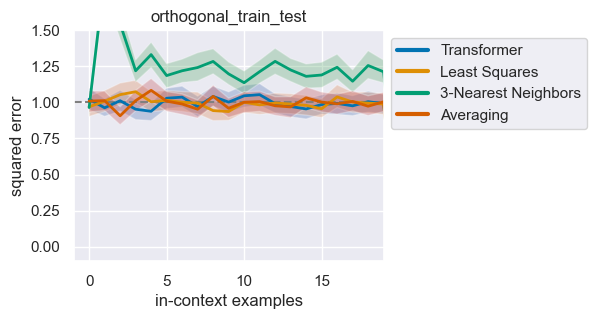

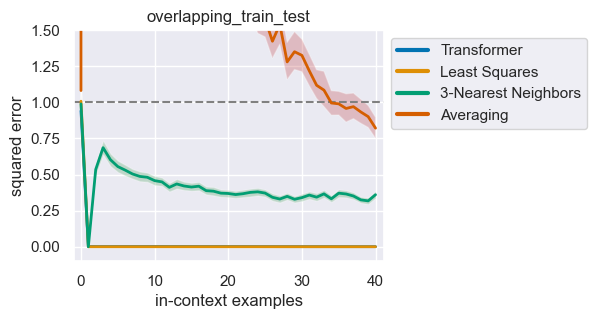

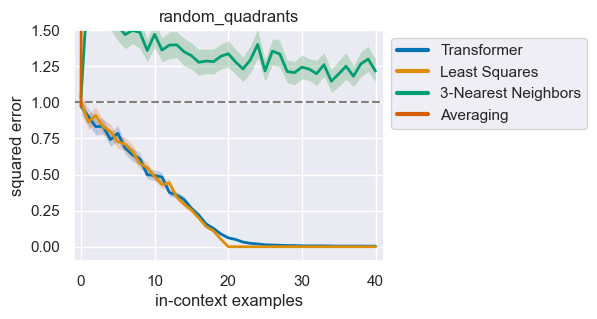

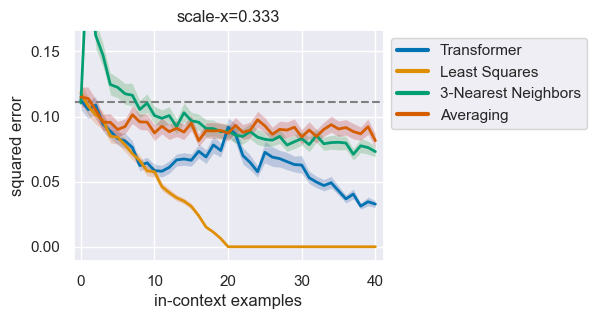

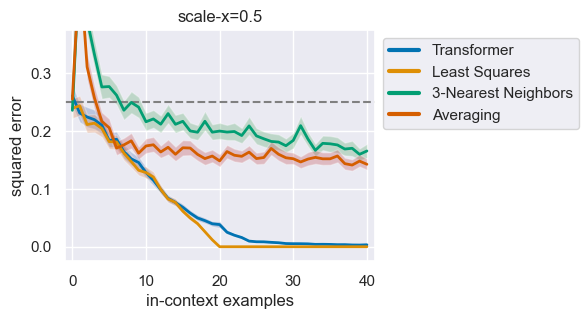

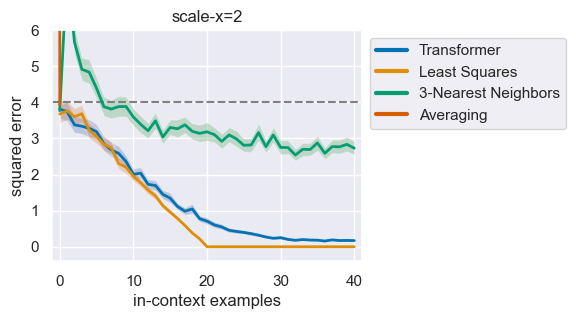

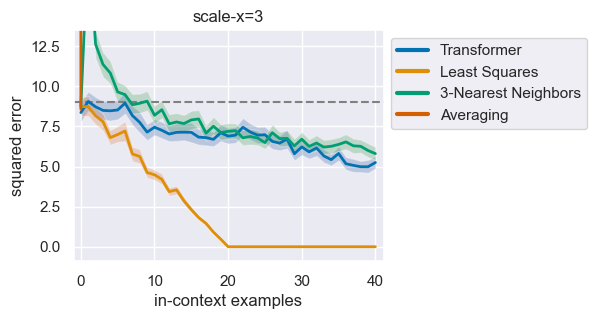

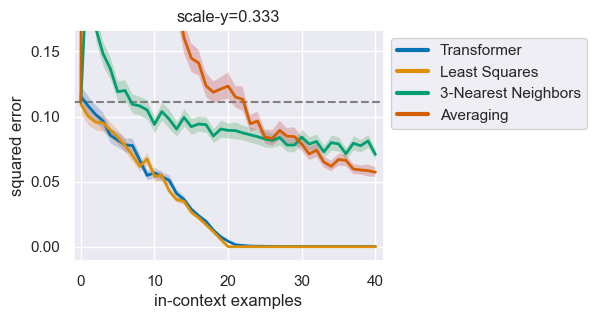

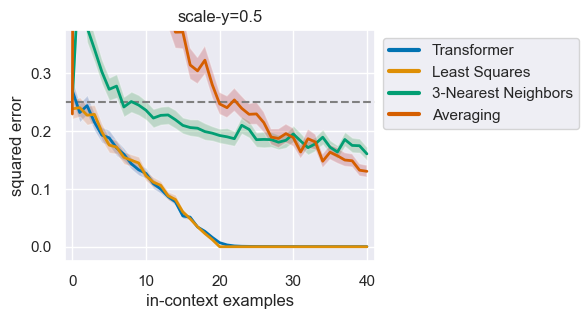

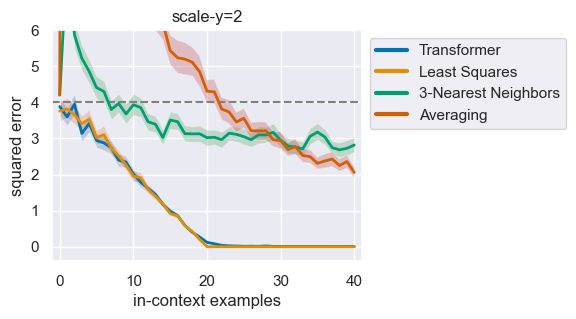

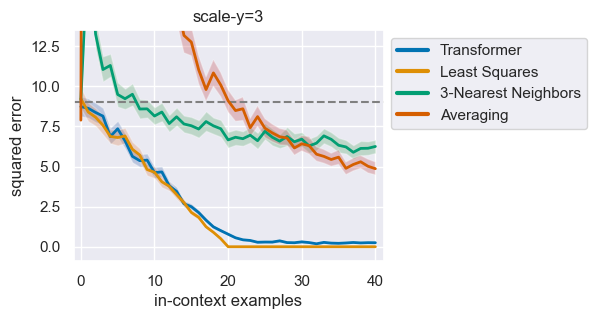

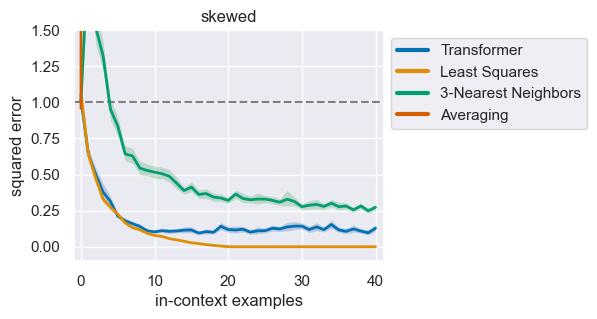

In [27]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    #plt.show() #this works for pre-computed - maps to some of the paper plots

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [28]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [ ]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims

# here is where I had to write some code in eval to skip some params not found
# for name, param in model.named_parameters():
#             print(f"Name: {name}, Shape: {param.shape}")


what is state path ../models/linear_regression/pretrained/state.pt
Name: _read_in.weight, Shape: torch.Size([256, 20])
Name: _read_in.bias, Shape: torch.Size([256])
Name: _backbone.wte.weight, Shape: torch.Size([50257, 256])
Name: _backbone.wpe.weight, Shape: torch.Size([202, 256])
Name: _backbone.h.0.ln_1.weight, Shape: torch.Size([256])
Name: _backbone.h.0.ln_1.bias, Shape: torch.Size([256])
Name: _backbone.h.0.attn.c_attn.weight, Shape: torch.Size([256, 768])
Name: _backbone.h.0.attn.c_attn.bias, Shape: torch.Size([768])
Name: _backbone.h.0.attn.c_proj.weight, Shape: torch.Size([256, 256])
Name: _backbone.h.0.attn.c_proj.bias, Shape: torch.Size([256])
Name: _backbone.h.0.ln_2.weight, Shape: torch.Size([256])
Name: _backbone.h.0.ln_2.bias, Shape: torch.Size([256])
Name: _backbone.h.0.mlp.c_fc.weight, Shape: torch.Size([256, 1024])
Name: _backbone.h.0.mlp.c_fc.bias, Shape: torch.Size([1024])
Name: _backbone.h.0.mlp.c_proj.weight, Shape: torch.Size([1024, 256])
Name: _backbone.h.0.mlp.

In [45]:
batch_size = conf.training.batch_size
#batch_size = 32

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [46]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

# batch size is 64
ys.shape, xs.shape

(torch.Size([64, 41]), torch.Size([64, 41, 20]))

In [47]:
with torch.no_grad():
    pred = model(xs, ys)

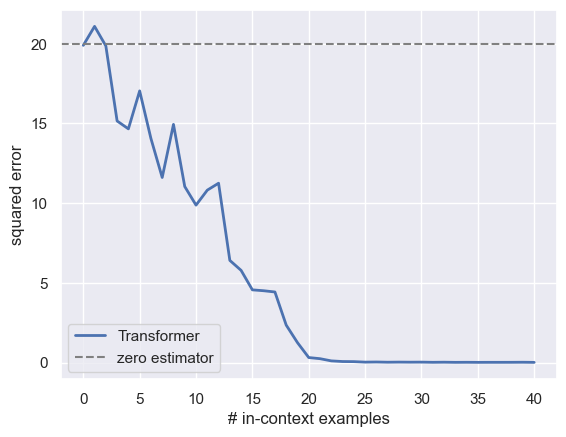

In [48]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [49]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

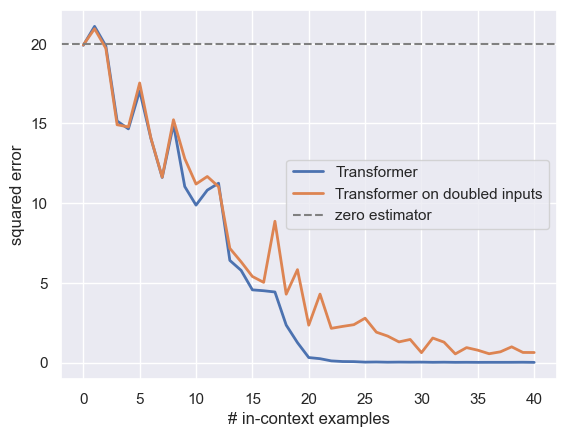

In [50]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.

In [ ]:
# alright, now I was able to evaluate the loaded model (at least for linear regression)
# next - see that I can train the toy model and see some learning.